In [48]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

plt.style.use("ggplot")

BASE_DATA_DIR = os.path.abspath("../data")
print("Using base data directory:", BASE_DATA_DIR)

Using base data directory: /work/data


In [49]:
json_files = glob(os.path.join(BASE_DATA_DIR, "**/*.json"), recursive=True)

print("Found JSON files:")
for f in json_files:
    print("  ", f)

print("\nTotal JSON files:", len(json_files))


Found JSON files:
   /work/data/AY1PC8/BullFlag_Detector_Labeling_AY1PC8.json
   /work/data/GFTYRV/project-4-at-2025-10-30-12-12-aaf7a367.json
   /work/data/J2QIYD/labels.json
   /work/data/XOBJYX/labels.json
   /work/data/YH6M5S/YH6M5S_labels.json

Total JSON files: 5


In [50]:
# DATA QUALITY DIAGNOSTIC: Check JSON files for annotation issues
import json
import os
from glob import glob

print("=" * 80)
print("JSON FILE DIAGNOSTIC REPORT")
print("=" * 80)

json_files = glob(os.path.join(BASE_DATA_DIR, "**/*.json"), recursive=True)

for json_path in json_files:
    folder = os.path.dirname(json_path)
    folder_name = os.path.basename(folder)
    
    print(f"\n📁 Folder: {folder_name}")
    print(f"   JSON: {os.path.basename(json_path)}")
    
    try:
        with open(json_path, "r", encoding="utf-8") as f:
            entries = json.load(f)
        
        # Count entries with actual annotations
        entries_with_labels = 0
        total_segments = 0
        missing_csvs = []
        
        for entry in entries:
            file_upload = entry.get("file_upload", "")
            annotations = entry.get("annotations", [])
            
            if annotations and annotations[0].get("result"):
                entries_with_labels += 1
                total_segments += len(annotations[0]["result"])
            
            # Check if CSV exists
            clean_name = file_upload.split("-", 1)[1] if "-" in file_upload else file_upload
            candidates = [
                os.path.join(folder, file_upload),
                os.path.join(folder, clean_name),
            ]
            if not any(os.path.exists(c) for c in candidates):
                missing_csvs.append(file_upload)
        
        print(f"   Total entries: {len(entries)}")
        print(f"   ✅ Entries with labeled segments: {entries_with_labels}")
        print(f"   📊 Total labeled segments: {total_segments}")
        
        if missing_csvs:
            print(f"   ⚠️  Missing CSV files: {len(missing_csvs)}")
            for csv in missing_csvs[:3]:  # Show first 3
                print(f"      - {csv}")
            if len(missing_csvs) > 3:
                print(f"      ... and {len(missing_csvs) - 3} more")
        else:
            print(f"   ✅ All CSV files found")
            
    except Exception as e:
        print(f"   ❌ ERROR: {e}")

print("\n" + "=" * 80)
print("AVAILABLE CSV FILES PER DIRECTORY:")
print("=" * 80)

for folder_path in [f.path for f in os.scandir(BASE_DATA_DIR) if f.is_dir() and f.name != 'export']:
    folder_name = os.path.basename(folder_path)
    csv_files = glob(os.path.join(folder_path, "*.csv"))
    print(f"\n📁 {folder_name}: {len(csv_files)} CSV files")
    if len(csv_files) <= 5:
        for csv in csv_files:
            print(f"   - {os.path.basename(csv)}")
    else:
        for csv in csv_files[:3]:
            print(f"   - {os.path.basename(csv)}")
        print(f"   ... and {len(csv_files) - 3} more")


JSON FILE DIAGNOSTIC REPORT

📁 Folder: AY1PC8
   JSON: BullFlag_Detector_Labeling_AY1PC8.json
   Total entries: 2
   ✅ Entries with labeled segments: 2
   📊 Total labeled segments: 77
   ✅ All CSV files found

📁 Folder: GFTYRV
   JSON: project-4-at-2025-10-30-12-12-aaf7a367.json
   Total entries: 27
   ✅ Entries with labeled segments: 26
   📊 Total labeled segments: 58
   ✅ All CSV files found

📁 Folder: J2QIYD
   JSON: labels.json
   Total entries: 60
   ✅ Entries with labeled segments: 60
   📊 Total labeled segments: 60
   ✅ All CSV files found

📁 Folder: XOBJYX
   JSON: labels.json
   Total entries: 3
   ✅ Entries with labeled segments: 3
   📊 Total labeled segments: 32
   ✅ All CSV files found

📁 Folder: YH6M5S
   JSON: YH6M5S_labels.json
   Total entries: 1
   ✅ Entries with labeled segments: 1
   📊 Total labeled segments: 54
   ✅ All CSV files found

AVAILABLE CSV FILES PER DIRECTORY:

📁 AY1PC8: 5 CSV files
   - EURUSD_15min_003.csv
   - EURUSD_1H_005.csv
   - EURUSD_1min_001.csv

In [51]:
def strip_guid(filename):
    """
    Converts 'e2ab0dd4-FILENAME.csv' → 'FILENAME.csv'.
    """
    base = os.path.basename(filename)
    parts = base.split("-", 1)
    if len(parts) == 2:
        print("Stripped GUID from", filename, "to", parts[1])
        return parts[1]
    print("Warning: could not strip GUID from", filename)
    return base


In [52]:
def extract_segments(json_entry, csv_directory):
    """
    Extracts all labeled time segments from the annotation entry.
    Loads the corresponding CSV and slices the time range.
    Returns a list of segment dicts.
    """

    # Check if file_upload key exists
    if "file_upload" not in json_entry:
        print("[extract_segments] WARNING: Entry missing 'file_upload' key, skipping")
        return []
    
    guid_name = json_entry["file_upload"]  # e.g., e2ab0dd4-GSPC_...
    
    # Handle None or empty file_upload
    if guid_name is None or guid_name == "":
        print("[extract_segments] WARNING: file_upload is None or empty, skipping")
        return []
    
    clean_name = strip_guid(guid_name)
    print(f"[extract_segments] file_upload={guid_name}, clean_name={clean_name}")

    # Try loading the CSV from several likely locations:
    #  - the JSON's folder (csv_directory)
    #  - the parent of that folder (handles e.g. J2QIYD/Labels vs J2QIYD/)
    #  - the global BASE_DATA_DIR
    candidate_dirs = [
        csv_directory,
        os.path.dirname(csv_directory),
        BASE_DATA_DIR,
    ]

    full_csv_path = None
    for d in candidate_dirs:
        if not d:
            continue
        candidates = [
            os.path.join(d, guid_name),
            os.path.join(d, clean_name),
        ]
        for path in candidates:
            if os.path.exists(path):
                full_csv_path = path
                break
        if full_csv_path is not None:
            break

    if full_csv_path is None:
        print("[extract_segments] WARNING: Cannot find CSV for annotation:", guid_name)
        return []

    print(f"[extract_segments] Using CSV: {full_csv_path}")

    try:
        df_csv = pd.read_csv(full_csv_path)
    except Exception as e:
        print("[extract_segments] ERROR reading CSV:", full_csv_path, e)
        return []

    # Normalize column names to lowercase for consistent access
    df_csv.columns = df_csv.columns.str.lower()
    
    # Normalize OHLC column names so we always have 'open', 'high', 'low', 'close'
    print(f"[extract_segments] CSV loaded with {len(df_csv)} rows and columns {list(df_csv.columns)}")

    # Convert timestamp column to string if it's numeric (Unix timestamp)
    if "timestamp" in df_csv.columns and pd.api.types.is_numeric_dtype(df_csv["timestamp"]):
        print(f"[extract_segments] Converting numeric timestamps to datetime strings")
        try:
            # Try Unix timestamp conversion (seconds)
            df_csv["timestamp"] = pd.to_datetime(df_csv["timestamp"], unit='s').dt.strftime('%Y-%m-%d %H:%M')
        except:
            try:
                # Try Unix timestamp conversion (milliseconds)
                df_csv["timestamp"] = pd.to_datetime(df_csv["timestamp"], unit='ms').dt.strftime('%Y-%m-%d %H:%M')
            except Exception as e:
                print(f"[extract_segments] WARNING: Could not convert timestamps: {e}")
                return []

    segments = []
    
    # Check if annotations exist
    if "annotations" not in json_entry or not json_entry["annotations"]:
        print(f"[extract_segments] WARNING: No annotations found for {guid_name}")
        return []
    
    annotation = json_entry["annotations"][0]

    if not annotation["result"]:
        print(f"[extract_segments] No labeled intervals in this entry for {guid_name}")

    for idx, result in enumerate(annotation["result"]):
        val = result["value"]

        start = val["start"]
        end = val["end"]
        label = val["timeserieslabels"][0]

        # Check if timestamp column exists for filtering
        if "timestamp" in df_csv.columns:
            seg_df = df_csv[(df_csv["timestamp"] >= start) & (df_csv["timestamp"] <= end)].copy()
        else:
            print(f"[extract_segments] WARNING: No timestamp column found in {guid_name}, skipping segment")
            continue

        seg_df.reset_index(drop=True, inplace=True)
        print(f"[extract_segments]  segment #{idx} label={label}, start={start}, end={end}, length={len(seg_df)}")

        segments.append({
            "csv_file": clean_name,
            "start": start,
            "end": end,
            "label": label,
            "length": len(seg_df),
            "segment_data": seg_df
        })

    print(f"[extract_segments] Total segments from {guid_name}: {len(segments)}")
    return segments


In [53]:
all_segments = []

print(f"[main] Found {len(json_files)} JSON files to process")

for i, json_path in enumerate(json_files):
    print(f"\n[main] ({i+1}/{len(json_files)}) Processing JSON:", json_path)

    folder = os.path.dirname(json_path)
    print(f"[main]  CSV search base directory: {folder}")

    try:
        with open(json_path, "r", encoding="utf-8") as f:
            entries = json.load(f)
        print(f"[main]  Loaded {len(entries)} annotation entries from JSON")
    except Exception as e:
        print("[main] ERROR reading JSON:", json_path, e)
        continue

    before_file = len(all_segments)
    for j, entry in enumerate(entries):
        print(f"[main]   Entry {j+1}/{len(entries)} for file_upload={entry.get('file_upload')}")
        segs = extract_segments(entry, folder)
        print(f"[main]   -> Extracted {len(segs)} segments from this entry")
        all_segments.extend(segs)
    after_file = len(all_segments)
    print(f"[main] Finished {json_path}: added {after_file - before_file} segments, total so far {after_file}")

print("\n[main] Total labeled segments loaded:", len(all_segments))


[main] Found 5 JSON files to process

[main] (1/5) Processing JSON: /work/data/AY1PC8/BullFlag_Detector_Labeling_AY1PC8.json
[main]  CSV search base directory: /work/data/AY1PC8
[main]  Loaded 2 annotation entries from JSON
[main]   Entry 1/2 for file_upload=351f4d2a-EURUSD_1H_005.csv
Stripped GUID from 351f4d2a-EURUSD_1H_005.csv to EURUSD_1H_005.csv
[extract_segments] file_upload=351f4d2a-EURUSD_1H_005.csv, clean_name=EURUSD_1H_005.csv
[extract_segments] Using CSV: /work/data/AY1PC8/EURUSD_1H_005.csv
[extract_segments] CSV loaded with 840 rows and columns ['timestamp', 'open', 'high', 'low', 'close']
[extract_segments] Converting numeric timestamps to datetime strings
[extract_segments]  segment #0 label=Bearish Normal, start=1707829200000, end=1707894000000, length=0
[extract_segments]  segment #1 label=Bearish Normal, start=1707872400000, end=1707872400000, length=0
[extract_segments]  segment #2 label=Bullish Normal, start=1708002000000, end=1708074000000, length=0
[extract_segment

In [54]:
df_meta = pd.DataFrame([{
    "csv_file": seg["csv_file"],
    "label": seg["label"],
    "start": seg["start"],
    "end": seg["end"],
    "length": seg["length"]
} for seg in all_segments])

df_meta


,csv_file,label,start,end,length
0,EURUSD_1H_005.csv,Bearish Normal,1707829200000,1707894000000,0
1,EURUSD_1H_005.csv,Bearish Normal,1707872400000,1707872400000,0
2,EURUSD_1H_005.csv,Bullish Normal,1708002000000,1708074000000,0
3,EURUSD_1H_005.csv,Bullish Normal,1706806800000,1706860800000,0
4,EURUSD_1min_001.csv,Bearish Normal,1704190200000,1704193620000,0
...,...,...,...,...,...
276,EURUSD_1H_001.csv,Bearish Pennant,2022-07-26 08:00,2022-07-27 13:00,30
277,EURUSD_1H_001.csv,Bullish Pennant,2022-08-10 09:00,2022-08-11 07:00,23
278,EURUSD_1H_001.csv,Bullish Normal,2022-09-07 14:00,2022-09-08 23:00,34
279,EURUSD_1H_001.csv,Bullish Pennant,2022-09-28 11:00,2022-09-29 12:00,26


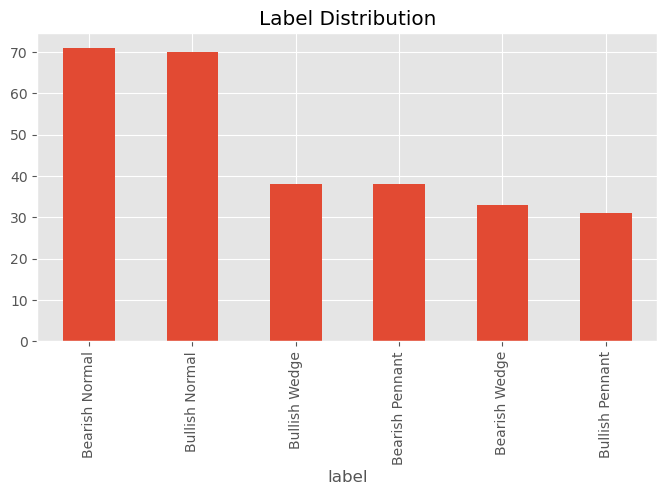

label
Bearish Normal     71
Bullish Normal     70
Bullish Wedge      38
Bearish Pennant    38
Bearish Wedge      33
Bullish Pennant    31
Name: count, dtype: int64

In [55]:
df_meta["label"].value_counts().plot(kind="bar", figsize=(8,4))
plt.title("Label Distribution")
plt.show()

df_meta["label"].value_counts()


Min length: 0
Max length: 393
Mean length: 19.569395017793596
Median length: 10.0


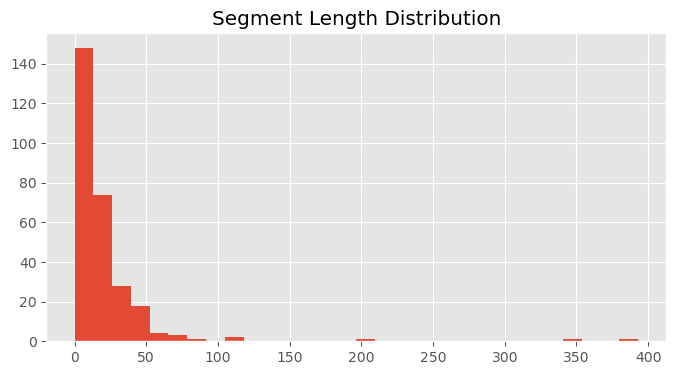

In [56]:
lengths = df_meta["length"].values

print("Min length:", lengths.min())
print("Max length:", lengths.max())
print("Mean length:", lengths.mean())
print("Median length:", np.median(lengths))

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30)
plt.title("Segment Length Distribution")
plt.show()


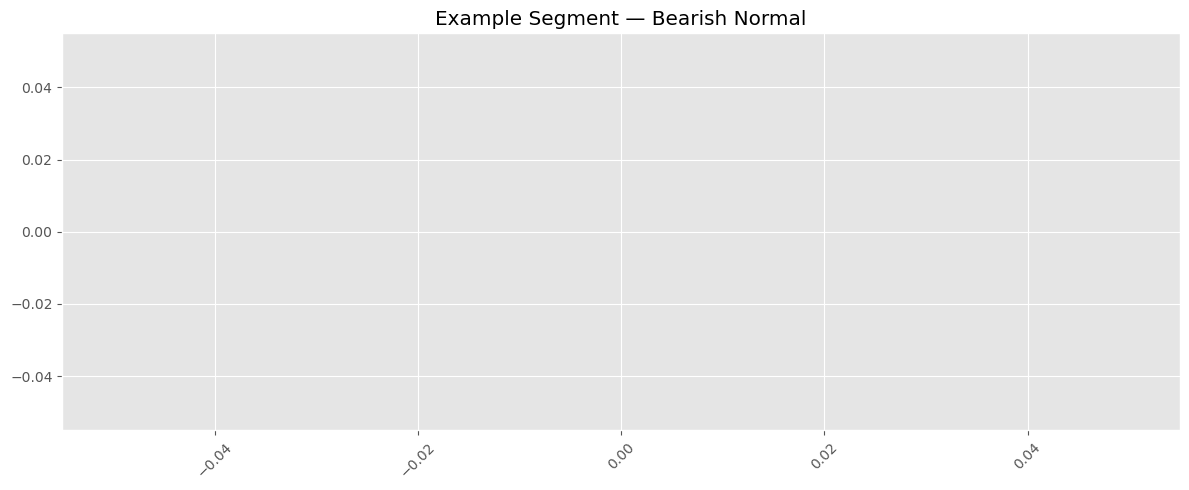

seg_df columns: Index(['timestamp', 'open', 'high', 'low', 'close'], dtype='object')
Empty DataFrame
Columns: [timestamp, open, high, low, close]
Index: []


In [57]:
sample = all_segments[0]
seg_df = sample["segment_data"]

plt.figure(figsize=(12,5))
plt.plot(seg_df["timestamp"], seg_df["close"], label="Close Price")
plt.title(f"Example Segment — {sample['label']}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("seg_df columns:", seg_df.columns)
print(seg_df.head())

In [58]:
dataset = []

for seg in all_segments:
    dataset.append({
        "label": seg["label"],
        "csv_file": seg["csv_file"],
        "data": seg["segment_data"]
    })

len(dataset)


281

In [59]:
print("Total labeled segments:", len(dataset))
print("Unique labels:", df_meta["label"].unique())
df_meta.describe()


Total labeled segments: 281
Unique labels: ['Bearish Normal' 'Bullish Normal' 'Bearish Wedge' 'Bullish Wedge'
 'Bearish Pennant' 'Bullish Pennant']


,length
count,281.000000
mean,19.569395
std,36.394117
min,0.000000
25%,0.000000
50%,10.000000
75%,25.000000
max,393.000000


In [60]:
# Create stratified train/test split at segment level
from sklearn.model_selection import train_test_split

# Get segment indices and labels
segment_indices = np.arange(len(all_segments))
segment_labels = [seg["label"] for seg in all_segments]

# Split with stratification to maintain label distribution
train_indices, test_indices = train_test_split(
    segment_indices,
    test_size=0.10,
    random_state=42,
    stratify=segment_labels
)

print("="*80)
print("STRATIFIED TRAIN/TEST SPLIT")
print("="*80)
print(f"Total segments: {len(all_segments)}")
print(f"Training segments: {len(train_indices)} ({len(train_indices)/len(all_segments)*100:.1f}%)")
print(f"Test segments: {len(test_indices)} ({len(test_indices)/len(all_segments)*100:.1f}%)")

# Verify stratification
train_label_dist = pd.Series([all_segments[i]["label"] for i in train_indices]).value_counts(normalize=True).sort_index()
test_label_dist = pd.Series([all_segments[i]["label"] for i in test_indices]).value_counts(normalize=True).sort_index()

print("\nLabel distribution (proportions):")
comparison_df = pd.DataFrame({
    'Train': train_label_dist,
    'Test': test_label_dist,
    'Overall': df_meta["label"].value_counts(normalize=True).sort_index()
})
print(comparison_df)
print("\n" + "="*80)

STRATIFIED TRAIN/TEST SPLIT
Total segments: 281
Training segments: 252 (89.7%)
Test segments: 29 (10.3%)

Label distribution (proportions):
                    Train      Test   Overall
Bearish Normal   0.253968  0.241379  0.252669
Bearish Pennant  0.134921  0.137931  0.135231
Bearish Wedge    0.115079  0.137931  0.117438
Bullish Normal   0.250000  0.241379  0.249110
Bullish Pennant  0.111111  0.103448  0.110320
Bullish Wedge    0.134921  0.137931  0.135231



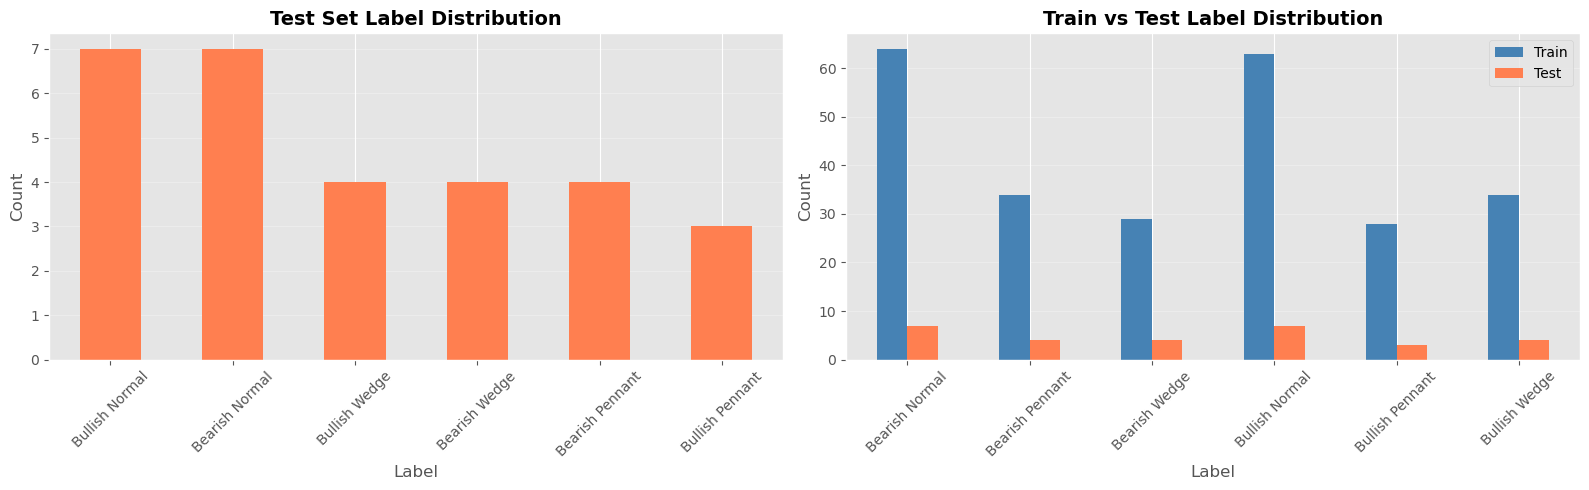

Test set label counts:
Bullish Normal     7
Bearish Normal     7
Bullish Wedge      4
Bearish Wedge      4
Bearish Pennant    4
Bullish Pennant    3
Name: count, dtype: int64

Test set total: 29 segments


In [61]:
# Visualize test set label distribution
import matplotlib.pyplot as plt

test_labels = [all_segments[i]["label"] for i in test_indices]
test_label_counts = pd.Series(test_labels).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Test set distribution
test_label_counts.plot(kind="bar", ax=axes[0], color='coral')
axes[0].set_title("Test Set Label Distribution", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Train vs Test comparison
train_labels = [all_segments[i]["label"] for i in train_indices]
comparison_counts = pd.DataFrame({
    'Train': pd.Series(train_labels).value_counts().sort_index(),
    'Test': pd.Series(test_labels).value_counts().sort_index()
})
comparison_counts.plot(kind="bar", ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title("Train vs Test Label Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(['Train', 'Test'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Test set label counts:")
print(test_label_counts)
print(f"\nTest set total: {len(test_labels)} segments")

In [ ]:
# Persist loaded data to the workspace data directory
import os
import pickle
import h5py
import numpy as np

EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
os.makedirs(EXPORT_DIR, exist_ok=True)
print("Exporting data to:", EXPORT_DIR)

# Create train and test segment lists
train_segments = [all_segments[i] for i in train_indices]
test_segments = [all_segments[i] for i in test_indices]

# 1) Save metadata summary (overall, train, test)
meta_csv_path = os.path.join(EXPORT_DIR, "segments_meta.csv")
df_meta.to_csv(meta_csv_path, index=False)
print("Saved metadata CSV:", meta_csv_path)

# Save train metadata
df_meta_train = df_meta.iloc[train_indices].reset_index(drop=True)
meta_train_path = os.path.join(EXPORT_DIR, "segments_meta_train.csv")
df_meta_train.to_csv(meta_train_path, index=False)
print("Saved train metadata CSV:", meta_train_path)

# Save test metadata
df_meta_test = df_meta.iloc[test_indices].reset_index(drop=True)
meta_test_path = os.path.join(EXPORT_DIR, "segments_meta_test.csv")
df_meta_test.to_csv(meta_test_path, index=False)
print("Saved test metadata CSV:", meta_test_path)

# 2) Save full segments to HDF5 (efficient, reloadable)
h5_path = os.path.join(EXPORT_DIR, "segments.h5")
with h5py.File(h5_path, "w") as h5:
    grp = h5.create_group("segments")
    for i, seg in enumerate(all_segments):
        sgrp = grp.create_group(str(i))
        # Store attributes
        sgrp.attrs["label"] = seg["label"]
        sgrp.attrs["csv_file"] = seg["csv_file"]
        sgrp.attrs["start"] = seg["start"]
        sgrp.attrs["end"] = seg["end"]
        sgrp.attrs["length"] = seg["length"]
        # Store the segment dataframe with numeric values only
        seg_df = seg["segment_data"].copy()
        cols = seg_df.columns.tolist()
        # If timestamp exists, replace it with a sequential integer index
        if "timestamp" in seg_df.columns:
            seq_index = np.arange(len(seg_df), dtype=np.int64)
            sgrp.create_dataset("seq_index", data=seq_index)
            seg_df = seg_df.drop(columns=["timestamp"])  # drop original timestamp
        
        # Coerce to numeric
        seg_df = seg_df.apply(pd.to_numeric, errors="coerce")
        # Store values
        for col in seg_df.columns:
            sgrp.create_dataset(col, data=seg_df[col].values)

print("Saved segments to HDF5:", h5_path)

# 3) Build combined CSV helper function
def build_combined_csv(segments, segment_indices, split_name=""):
    """Build combined CSV from segments with given indices"""
    rows = []
    for new_id, orig_idx in enumerate(segment_indices):
        seg = segments[orig_idx]
        seg_df = seg["segment_data"].copy()
        # Build sequential index regardless of timestamp presence
        seq_index = np.arange(len(seg_df), dtype=np.int64)
        # Drop timestamp if present
        if "timestamp" in seg_df.columns:
            seg_df = seg_df.drop(columns=["timestamp"])  # numeric columns remain
        # Coerce to numeric
        seg_df = seg_df.apply(pd.to_numeric, errors="coerce")
        # Attach metadata and seq index
        seg_df.insert(0, "seq_index", seq_index)
        seg_df.insert(0, "csv_file", seg["csv_file"])
        seg_df.insert(0, "label", seg["label"])
        seg_df.insert(0, "segment_id", new_id)
        seg_df.insert(0, "original_id", orig_idx)
        rows.append(seg_df)
    
    if rows:
        combined = pd.concat(rows, axis=0, ignore_index=True)
        combined = combined.sort_values(["segment_id", "seq_index"], kind="mergesort").reset_index(drop=True)
        return combined
    return None

# Save combined CSV for all segments
combined_csv_path = os.path.join(EXPORT_DIR, "segments_values.csv")
combined_df = build_combined_csv(all_segments, segment_indices)
if combined_df is not None:
    combined_df.to_csv(combined_csv_path, index=False)
    print("Saved combined segments CSV:", combined_csv_path)

# Save train split
combined_train_path = os.path.join(EXPORT_DIR, "segments_values_train.csv")
combined_train_df = build_combined_csv(all_segments, train_indices, "train")
if combined_train_df is not None:
    combined_train_df.to_csv(combined_train_path, index=False)
    print("Saved train segments CSV:", combined_train_path)

# Save test split
combined_test_path = os.path.join(EXPORT_DIR, "segments_values_test.csv")
combined_test_df = build_combined_csv(all_segments, test_indices, "test")
if combined_test_df is not None:
    combined_test_df.to_csv(combined_test_path, index=False)
    print("Saved test segments CSV:", combined_test_path)

print("\nSplit summary:")
print(f"  Total segments: {len(all_segments)}")
print(f"  Train segments: {len(train_indices)} ({len(train_indices)/len(all_segments)*100:.1f}%)")
print(f"  Test segments: {len(test_indices)} ({len(test_indices)/len(all_segments)*100:.1f}%)")


SyntaxError: invalid syntax (3788623520.py, line 104)

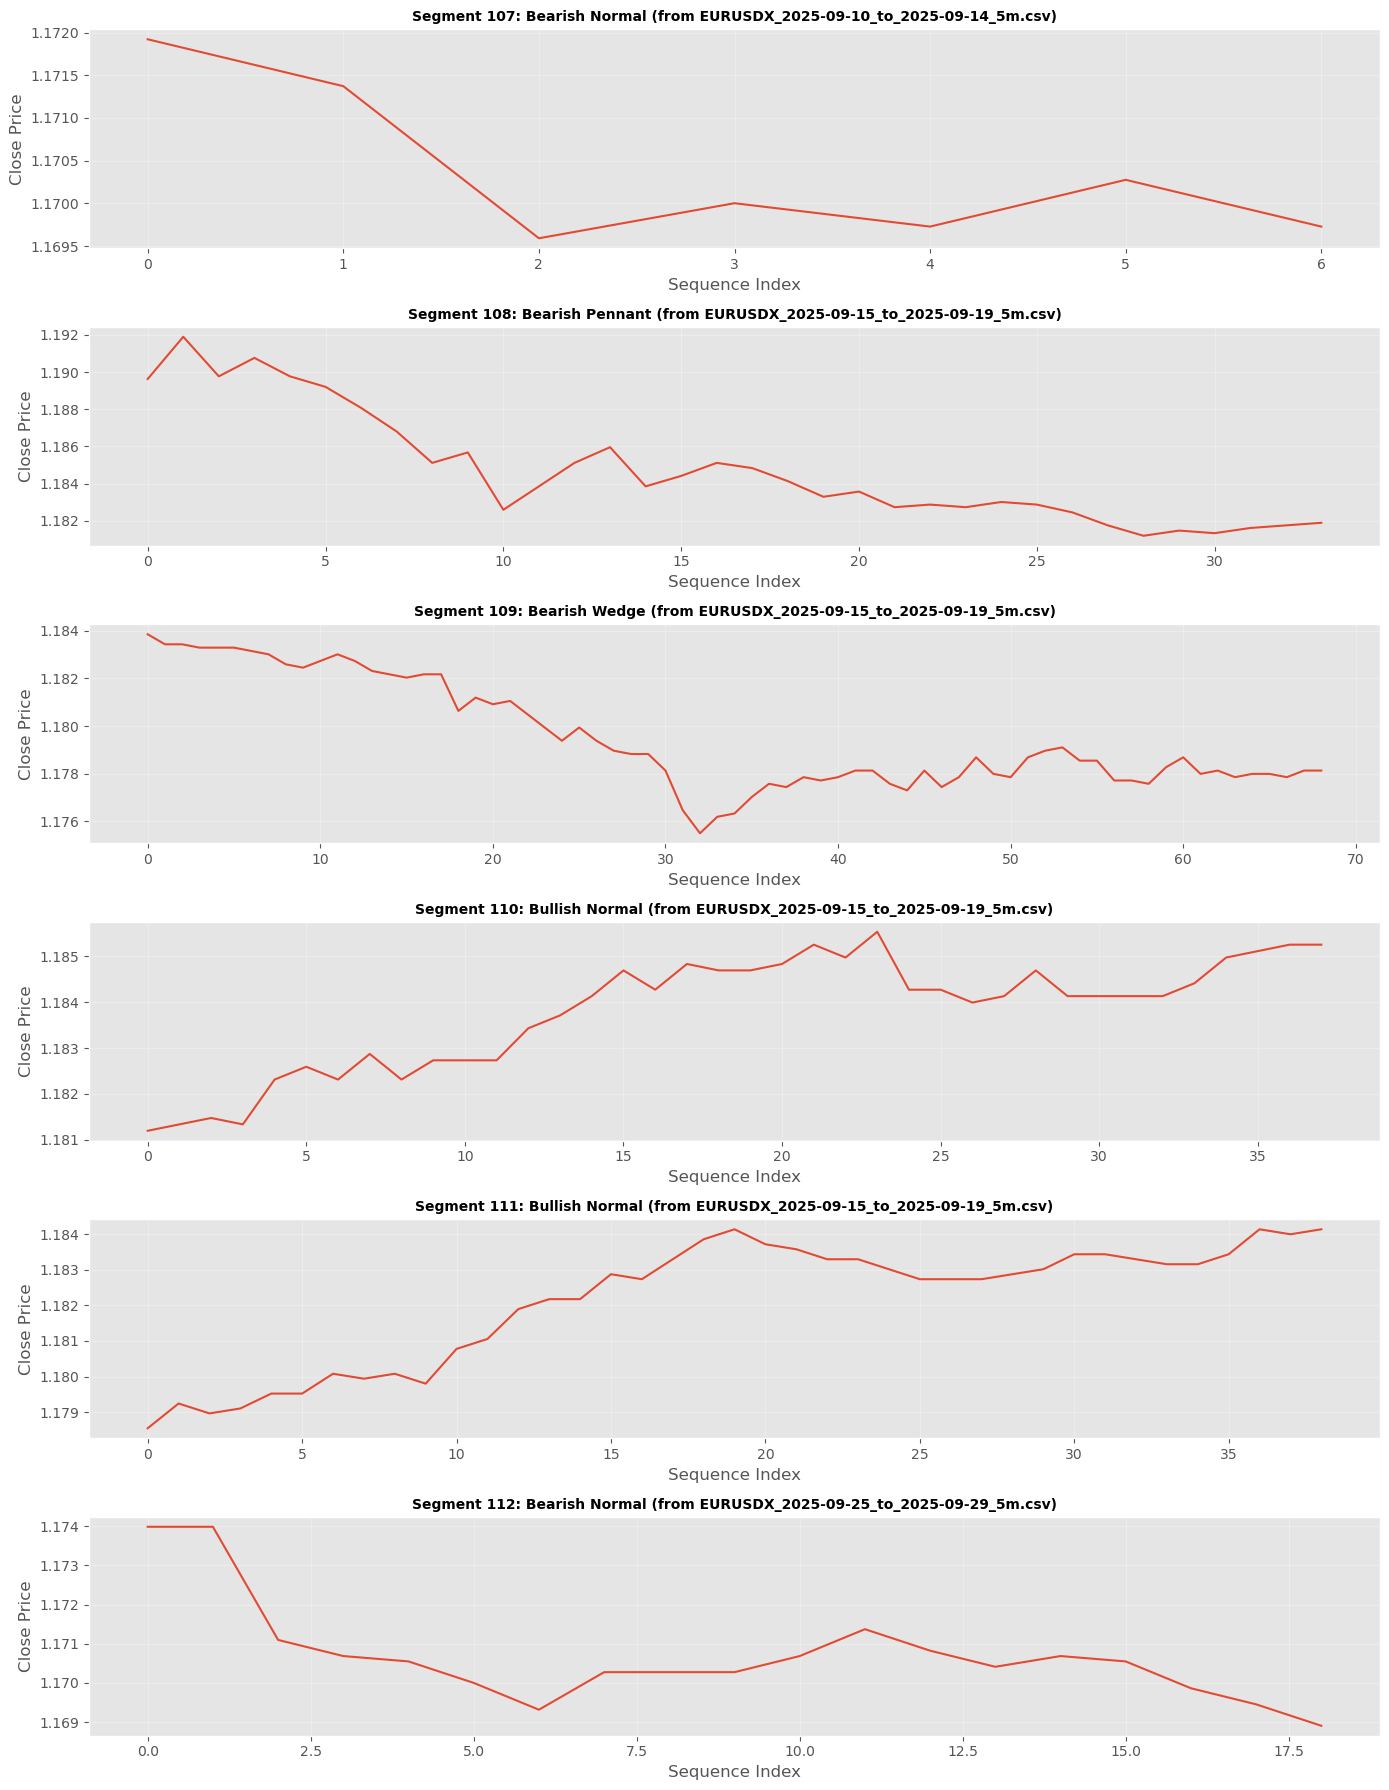

Displayed 6 segments out of 174 total segments


In [ ]:
# Visualize a sample of segments from combined_df
import matplotlib.pyplot as plt

# Get unique segment IDs
unique_segments = combined_df['segment_id'].unique()[30:]

# Plot first 6 segments (or fewer if less available)
n_plots = min(6, len(unique_segments))
fig, axes = plt.subplots(n_plots, 1, figsize=(14, 3*n_plots))

if n_plots == 1:
    axes = [axes]

for idx, seg_id in enumerate(unique_segments[:n_plots]):
    seg_data = combined_df[combined_df['segment_id'] == seg_id]
    label = seg_data['label'].iloc[0]
    csv_file = seg_data['csv_file'].iloc[0]
    
    # Plot the Close price
    axes[idx].plot(seg_data['seq_index'], seg_data['close'], linewidth=1.5)
    axes[idx].set_title(f"Segment {seg_id}: {label} (from {csv_file})", fontsize=10, fontweight='bold')
    axes[idx].set_xlabel("Sequence Index")
    axes[idx].set_ylabel("Close Price")
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Displayed {n_plots} segments out of {len(unique_segments)} total segments")

In [ ]:
# Diagnostic: summarize extracted segments per CSV file
from collections import Counter

if not all_segments:
    print("[diag] No segments extracted yet. Run the earlier cells first.")
else:
    seg_counts = Counter()
    label_counts = {}  # csv_file -> Counter of labels
    for seg in all_segments:
        csv_file = seg["csv_file"]
        label = seg["label"]
        seg_counts[csv_file] += 1
        label_counter = label_counts.setdefault(csv_file, Counter())
        label_counter[label] += 1

    rows = []
    for csv_file, count in seg_counts.items():
        row = {
            "csv_file": csv_file,
            "segment_count": count,
        }
        # Expand label distribution into separate columns for quick inspection
        for label, c in label_counts[csv_file].items():
            col_name = f"label_{label}"
            row[col_name] = c
        rows.append(row)

    seg_summary_df = pd.DataFrame(rows)
    seg_summary_df = seg_summary_df.sort_values("segment_count", ascending=False).reset_index(drop=True)

    print("[diag] Segment counts per CSV file:")
    display(seg_summary_df)

[diag] Segment counts per CSV file:


,csv_file,segment_count,label_Bearish Normal,label_Bullish Normal,label_Bullish Pennant,label_Bearish Wedge,label_Bullish Wedge,label_Bearish Pennant
0,EURUSD_1min_001.csv,73,27.0,15.0,5.0,8.0,12.0,6.0
1,EURUSD_1H_001.csv,55,12.0,17.0,11.0,5.0,4.0,6.0
2,XAUUSD_15min.csv,14,3.0,3.0,NaN,3.0,3.0,2.0
3,XAUUSD_5min.csv,10,3.0,4.0,2.0,NaN,NaN,1.0
4,XAUUSD_30min.csv,8,4.0,2.0,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...
85,EURUSD_1H_056.csv,1,1.0,NaN,NaN,NaN,NaN,NaN
86,EURUSD_1H_059.csv,1,1.0,NaN,NaN,NaN,NaN,NaN
87,EURUSD_1H_058.csv,1,1.0,NaN,NaN,NaN,NaN,NaN
88,EURUSD_1H_057.csv,1,1.0,NaN,NaN,NaN,NaN,NaN
